In [1]:
!python -V

Python 3.6.8


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q /content/drive/My\ Drive/DatasetFacens/DATASET.zip -d /content/

In [5]:
!unzip -q /content/drive/My\ Drive/DatasetFacens/FCN-pytorch-master.zip -d /content/

unzip:  cannot find or open /content/drive/My Drive/DatasetFacens/FCN-pytorch-master.zip, /content/drive/My Drive/DatasetFacens/FCN-pytorch-master.zip.zip or /content/drive/My Drive/DatasetFacens/FCN-pytorch-master.zip.ZIP.


In [17]:
### finding image files

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import glob
8
files = sorted(glob.glob("DATASET/*/*.png"))
X = []
y = []

for i in range(len(files)):
  if "image_training" in files[i]:
    X.append(files[i])
  if "mask_training" in files[i]:
    y.append(files[i])

del files

print(len(X),len(y))
print(X[0:5])
print(y[0:5])

400 400
['DATASET/image_training/fc_00001.png', 'DATASET/image_training/fc_00002.png', 'DATASET/image_training/fc_00003.png', 'DATASET/image_training/fc_00004.png', 'DATASET/image_training/fc_00005.png']
['DATASET/mask_training/fc_road_00001.png', 'DATASET/mask_training/fc_road_00002.png', 'DATASET/mask_training/fc_road_00003.png', 'DATASET/mask_training/fc_road_00004.png', 'DATASET/mask_training/fc_road_00005.png']


In [18]:
files = sorted(glob.glob("DATASET/*/*.png"))
X_test = []
y_test = []

for i in range(len(files)):
  if "image_test" in files[i]:
    X_test.append(files[i])
  if "mask_test" in files[i]:
    y_test.append(files[i])

del files

print(len(X_test),len(y_test))
print(X_test[0:5])
print(y_test[0:5])

70 70
['DATASET/image_test/fc_00401.png', 'DATASET/image_test/fc_00402.png', 'DATASET/image_test/fc_00403.png', 'DATASET/image_test/fc_00404.png', 'DATASET/image_test/fc_00405.png']
['DATASET/mask_test/fc_road_00401.png', 'DATASET/mask_test/fc_road_00402.png', 'DATASET/mask_test/fc_road_00403.png', 'DATASET/mask_test/fc_road_00404.png', 'DATASET/mask_test/fc_road_00405.png']


In [0]:
import cv2
import numpy as np

h, w, c = 500, 1280, 3
nh, nw = int(h/5), int(w/5)

class JuanDataset(Dataset):
  def __init__(self, X, y, resize=True):
    self.data = X
    self.target = y
    self.resize = resize
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img = cv2.imread(self.data[idx])
    img = cv2.resize(img, (nw, nh))
    img = np.moveaxis(img, 2, 0)
    img = img / 255
    #img = img.mean(axis=2)

    label = cv2.imread(self.target[idx])
    if self.resize:
      label = cv2.resize(label, (nw, nh))
    label = np.moveaxis(label, 2, 0)
    #label = label.mean(axis=2)
    label = label / 255

    return torch.Tensor(img), torch.Tensor(label)

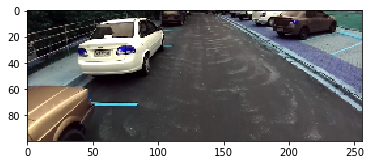

In [36]:
from matplotlib import pyplot as plt

train_data = JuanDataset(X, y)
test_data  = JuanDataset(X_test, y_test)
batch_size = 4

plt.imshow(np.moveaxis(test_data[0][0].detach().numpy(),0,2))

dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=4)

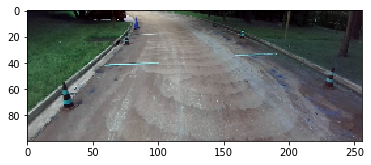

In [37]:
plt.imshow(np.moveaxis(train_data[0][0].detach().numpy(),0,2))

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4.74M/4.74M [00:00<00:00, 8.25MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 49, 127]           1,792
              ReLU-2          [-1, 64, 49, 127]               0
         MaxPool2d-3           [-1, 64, 24, 63]               0
            Conv2d-4           [-1, 16, 24, 63]           1,040
              ReLU-5           [-1, 16, 24, 63]               0
            Conv2d-6           [-1, 64, 24, 63]           1,088
              ReLU-7           [-1, 64, 24, 63]               0
            Conv2d-8           [-1, 64, 24, 63]           9,280
              ReLU-9           [-1, 64, 24, 63]               0
             Fire-10          [-1, 128, 24, 63]               0
           Conv2d-11           [-1, 16, 24, 63]           2,064
             ReLU-12           [-1, 16, 24, 63]               0
           Conv2d-13           [-1, 64, 24, 63]           1,088
             ReLU-14           [-1, 64,

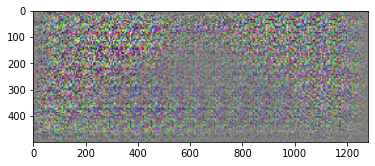

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchsummary import summary

import torchvision.models as models
squeezenet = models.squeezenet1_1(pretrained=True)

h, w, c = 500, 1280, 3

class JuanSqueezeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.squeezenet_model = squeezenet.features
    self.layer1 = nn.Sequential(
        nn.ReLU(),
        nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
        nn.BatchNorm2d(512),
        nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 3, kernel_size=(4,10), stride=1, padding=1, dilation=2),
        nn.BatchNorm2d(3),
    )
    self.classifier = nn.Sigmoid()

  def forward(self, x):
    output = self.squeezenet_model(x)
    output = self.layer1(output)
    output = self.classifier(output.view(len(x),-1))
    return output.view(len(x), c, nh, nw)

net = JuanSqueezeNet()

if torch.cuda.is_available():
    net.cuda()

summary(net, (3, 100, 256))

train_data = JuanDataset(X, y)
batch_size = 4
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=4)

for i, batch in enumerate(dataloader):

  img  = batch[0][0].detach().numpy()

  # f, axarr = plt.subplots(2, figsize=(8, 8))
  # axarr[0].imshow(np.moveaxis(batch[0][0].detach().numpy(), 0, 2))
  # axarr[1].imshow(np.moveaxis(batch[1][0].detach().numpy(), 0, 2))

  mask = net.forward(torch.Tensor([img]).cuda())[0].cpu().detach().numpy()
  print(mask.shape)
  mask = np.moveaxis(mask, 0, 2)
  mask = cv2.resize(mask, (w, h))
  print(mask.shape)
  plt.imshow(mask)

  break

In [39]:
batch_size = 10
epochs     = 50
lr         = 1e-3
momentum   = 0
w_decay    = 1e-5
step_size  = 50
gamma      = 0.5

import time

net = JuanSqueezeNet()

if torch.cuda.is_available():
    net.cuda()

criterion = nn.BCELoss()
optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=momentum, weight_decay=w_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

use_gpu = torch.cuda.is_available()

for epoch in range(epochs):
  scheduler.step()

  ts = time.time()
  for iter, batch in enumerate(dataloader):
      optimizer.zero_grad()

      if torch.cuda.is_available():
          inputs = Variable(batch[0].cuda())
          labels = Variable(batch[1].cuda())
      else:
          inputs, labels = Variable(batch[0]), Variable(batch[1])

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      if iter % 10 == 0:
          print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))

torch.save(net.state_dict(), "/content/model_saved")

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch0, iter0, loss: 0.7970128655433655
epoch0, iter10, loss: 0.6455304026603699
epoch0, iter20, loss: 0.6103192567825317
epoch0, iter30, loss: 0.584883987903595
epoch0, iter40, loss: 0.5667105317115784
epoch0, iter50, loss: 0.5571749806404114
epoch0, iter60, loss: 0.543612003326416
epoch0, iter70, loss: 0.53729647397995
epoch0, iter80, loss: 0.5286139249801636
epoch0, iter90, loss: 0.5213868021965027
epoch1, iter0, loss: 0.5195990800857544
epoch1, iter10, loss: 0.5082725286483765
epoch1, iter20, loss: 0.5036308765411377
epoch1, iter30, loss: 0.4963999390602112
epoch1, iter40, loss: 0.4980217516422272
epoch1, iter50, loss: 0.4875795543193817
epoch1, iter60, loss: 0.4892374575138092
epoch1, iter70, loss: 0.48634886741638184
epoch1, iter80, loss: 0.48426422476768494
epoch1, iter90, loss: 0.47799891233444214
epoch2, iter0, loss: 0.4702196717262268
epoch2, iter10, loss: 0.46308717131614685
epoch2, iter20, loss: 0.4603419899940491
epoch2, iter30, loss: 0.46032288670539856
epoch2, iter40, lo

In [0]:
# This methods expects arrays in the following shape: (height, width, 1)
# Where the last dimension contains only zeroes (no mask), and ones (mask)
from sklearn.metrics import confusion_matrix  
import numpy as np

def calculate_IoU(y_pred, y_true):

    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)


In [0]:
test_data = JuanDataset(X_test, y_test, resize=False)

net = JuanSqueezeNet()
net.cuda()
net.load_state_dict(torch.load("/content/model_saved_b-10_e-150_lr-1e-3_s-50_g-0-5.pth"))
net.eval()

plot_img = False
mask_idx = 0

batch_size = 4
dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
image = 0

test_iou_results = []

for i, batch in enumerate(dataloader):
  
  for j in range(len(batch[0])):
    img  = batch[0][j].detach().numpy()

    pred_mask = net.forward(torch.Tensor([img]).cuda())[0].cpu().detach().numpy()
    
    pred_mask = np.moveaxis(pred_mask, 0, 2)
    pred_mask = cv2.resize(pred_mask, (w, h))

    mn = mask.mean()

    pred_mask[pred_mask < mn] = 0
    pred_mask[pred_mask >= mn] = 1
    true_mask = np.moveaxis(batch[1][j].detach().numpy(), 0, 2)

    # Calculate IoU between pred_mask and true_mask
    test_iou_results.append( calculate_IoU(pred_mask[:,:,mask_idx], true_mask[:,:,mask_idx]) )

    if plot_img:
        f, axarr = plt.subplots(3, figsize=(8, 8))
        axarr[0].imshow(pred_mask[:,:,0], cmap='gray')
        axarr[1].imshow(np.moveaxis(img, 0, 2))
        axarr[2].imshow(true_mask[:,:,0], cmap='gray')

    # image+=1
    # if image == batch_size:
    #     break

In [100]:
np.mean(test_iou_results)
np.std(test_iou_results)

0.02667920523372383

In [0]:
train_data = JuanDataset(X, y, resize=False)

net = JuanSqueezeNet()
net.cuda()
net.load_state_dict(torch.load("/content/model_saved_b-10_e-150_lr-1e-3_s-50_g-0-5.pth"))
net.eval()

plot_img = False
mask_idx = 0

batch_size = 40.9734985933197384
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=4)
image = 0

train_iou_results = []

for i, batch in enumerate(dataloader):
  
  for j in range(len(batch[0])):
    img  = batch[0][j].detach().numpy()

    pred_mask = net.forward(torch.Tensor([img]).cuda())[0].cpu().detach().numpy()
    
    pred_mask = np.moveaxis(pred_mask, 0, 2)
    pred_mask = cv2.resize(pred_mask, (w, h))

    mn = mask.mean()

    pred_mask[pred_mask < mn] = 0
    pred_mask[pred_mask >= mn] = 1
    true_mask = np.moveaxis(batch[1][j].detach().numpy(), 0, 2)

    # Calculate IoU between pred_mask and true_mask
    train_iou_results.append( calculate_IoU(pred_mask[:,:,mask_idx], true_mask[:,:,mask_idx]) )

    if plot_img:
        f, axarr = plt.subplots(3, figsize=(8, 8))
        axarr[0].imshow(pred_mask[:,:,0], cmap='gray')
        axarr[1].imshow(np.moveaxis(img, 0, 2))
        axarr[2].imshow(true_mask[:,:,0], cmap='gray')

    # image+=1
    # if image == batch_size:
    #     break

In [101]:
np.mean(train_iou_results)
np.std(train_iou_results)

0.015984509303919568